## Time-Series Forecasting
### Exponential Smoothing: sktime

#### Agenda:
* Generate time-series data using NumPy
* Split into train and test sets
* Set up expanding window cross-validation 
* Perform hyperparameter tuning
* Use best model to make forecasts
* Compare predictions to actuals
* Briefly assess accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

#### Generate Time Series (insert your own dataset here)

In [2]:
np.random.seed(42)

# 2 years of daily data
days = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
n = len(days)

trend = np.linspace(50, 150, n)

# Yearly seasonality
yearly = 20 * np.sin(2 * np.pi * np.arange(n)/365)

# Weekly seasonality
weekly = 5 * np.sin(2 * np.pi * np.arange(n)/7)

noise = np.random.normal(0, 2, n)

# Combine components
data = trend + yearly + weekly + noise

# Create pandas series
ts = pd.Series(data, index=days)
ts.head()

2023-01-01    50.993428
2023-01-02    54.113882
2023-01-03    57.132421
2023-01-04    56.658831
2023-01-05    49.286268
Freq: D, dtype: float64

#### Visualize Time Series

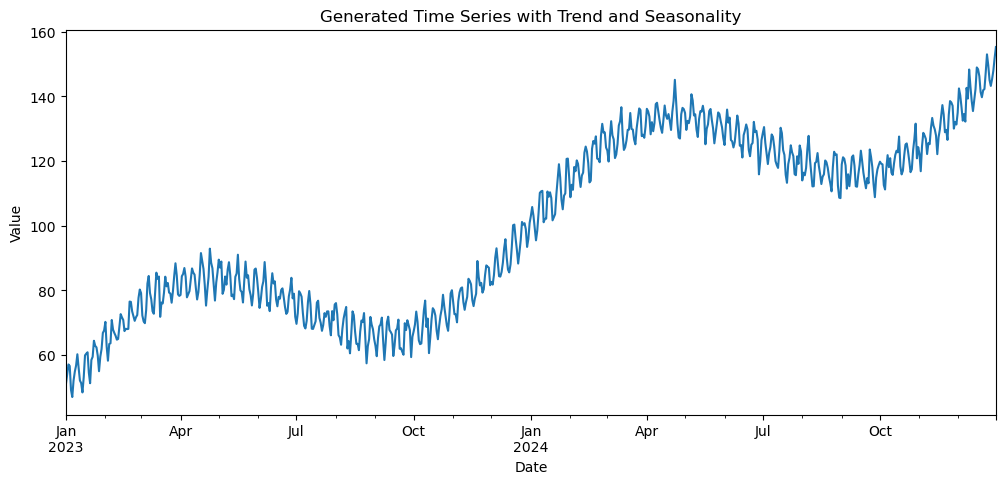

In [3]:
ts.plot(title="Generated Time Series with Trend and Seasonality", figsize=(12,5))
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

#### Train/Test Split

In [4]:
y_train, y_test = temporal_train_test_split(ts, test_size=30)

In [5]:
print(y_train.shape, y_test.shape)

(701,) (30,)


#### Expanding window cross-validator setup and visualization

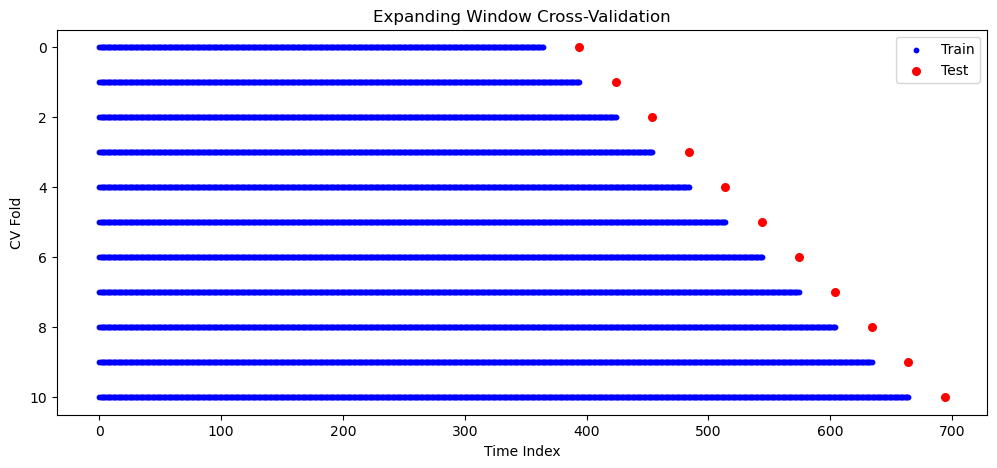

In [6]:
cv = ExpandingWindowSplitter(initial_window=365, step_length=30, fh=30)

plt.figure(figsize=(12, 5))

for i, (train_idx, test_idx) in enumerate(cv.split(y_train)):
    plt.scatter(train_idx, [i]*len(train_idx), color='blue', s=10, label='Train' if i==0 else "")
    plt.scatter(test_idx, [i]*len(test_idx), color='red', s=30, label='Test' if i==0 else "")

plt.xlabel("Time Index")
plt.ylabel("CV Fold")
plt.gca().invert_yaxis()
plt.title("Expanding Window Cross-Validation")
plt.legend()
plt.show()

#### Hyperparameter Tuning

In [7]:
param_grid = {
    "trend": [None, "add", "mul"],      # none=relatively constant moving average
    "damped_trend": [False, True],      # trend test for flattening trend over time
    "seasonal": [None, "add", "mul"],   # no seasonality, additive, multiplicative
    "sp": [7, 30, 365],                 # weekly, monthly (approx), yearly seasonality
}

# default error metric is mean absolute scaled error (MASE)
gscv = ForecastingGridSearchCV(
    ExponentialSmoothing(),
    cv=cv,
    param_grid=param_grid
)
gscv.fit(y_train)

print("Best parameters found:", gscv.best_params_)

Best parameters found: {'damped_trend': True, 'seasonal': 'add', 'sp': 7, 'trend': 'add'}


#### Predict with best model and forecast 30 days ahead

In [8]:
best_model = gscv.best_forecaster_

# Forecast next 30 days
fh = list(range(1, 31))
y_pred = best_model.predict(fh=fh)

#### Visualize Forecast vs. Actuals

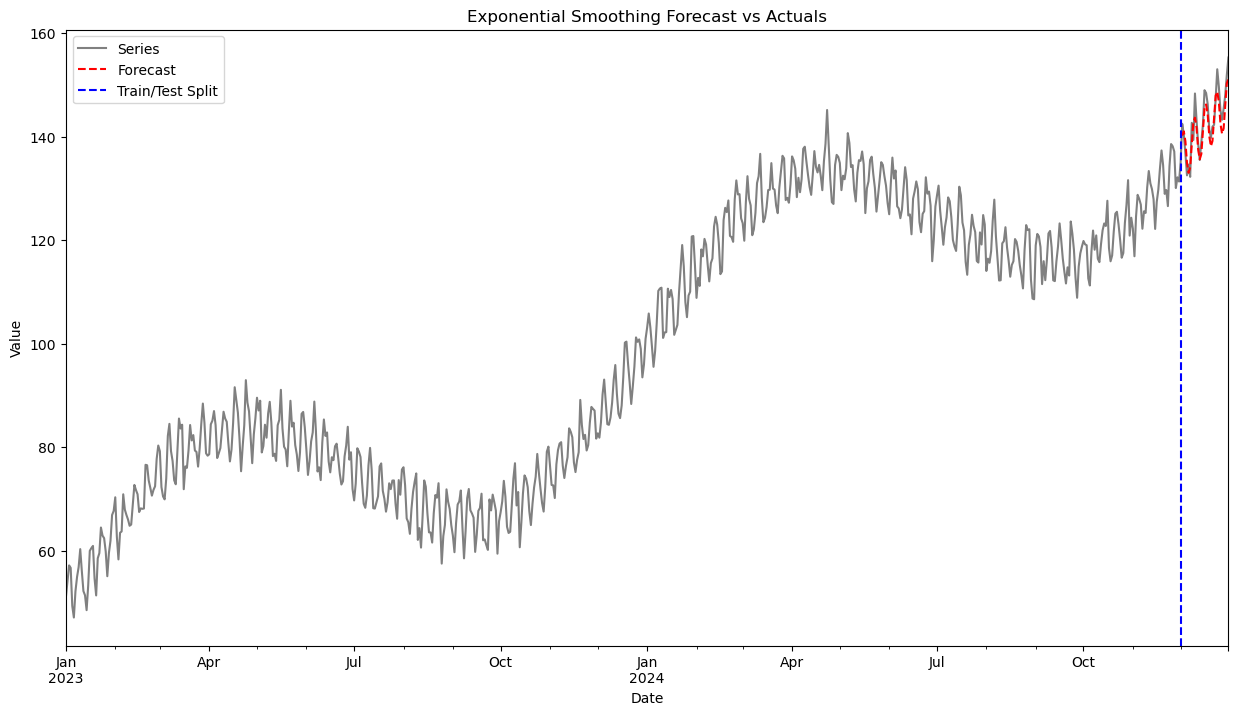

In [9]:
plt.figure(figsize=(15,8))
ts.plot(label='Series', color='gray')
y_pred.plot(label='Forecast', style='--', color='red')
plt.axvline(y_train.index[-1], color='blue', linestyle='--', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Exponential Smoothing Forecast vs Actuals")
plt.legend()
plt.show()

#### Assess accuracy

In [10]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MAPE: 0.015900045327595286
